In [1]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

GAME_STATE_FILE_NAME = "game"
GAME_STATE_FILE_EXT = ".csv"
GAMES_DIR = "games/"
PROCESSED_GAMES_DIR = "processed_games/"
MODEL_NAME = "2048_model.h5"
MOVES = ["UP", "DOWN", "LEFT", "RIGHT"]
MOVE_COL_NAME = "MOVE"
FILE_HEADER = [""]
N_SIZE = 4
N_FILES = 18
MIN_CELL_VALUE_TO_QUALIFY = 32

def load_data(file, direc=GAMES_DIR, header=True):
    csv_path = os.path.join(direc, file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

Graphs for game 0 :



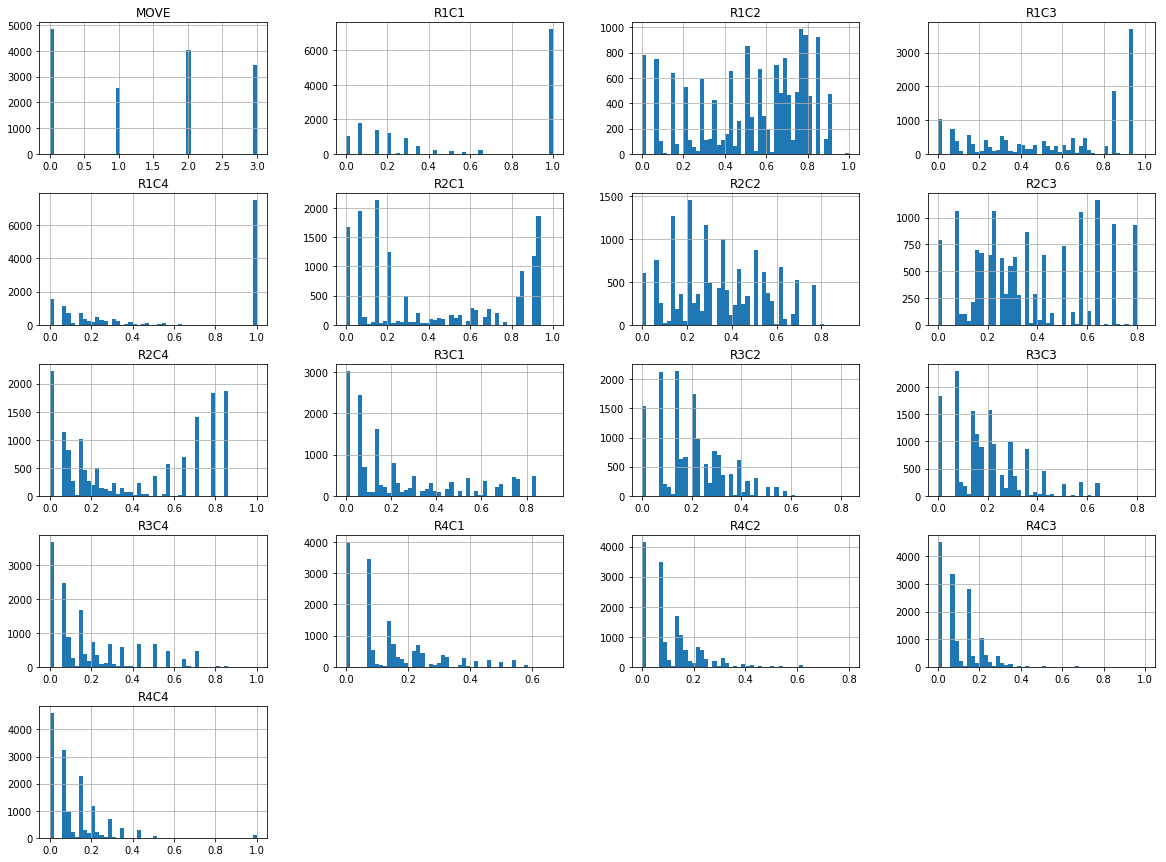

Graphs for game 1 :



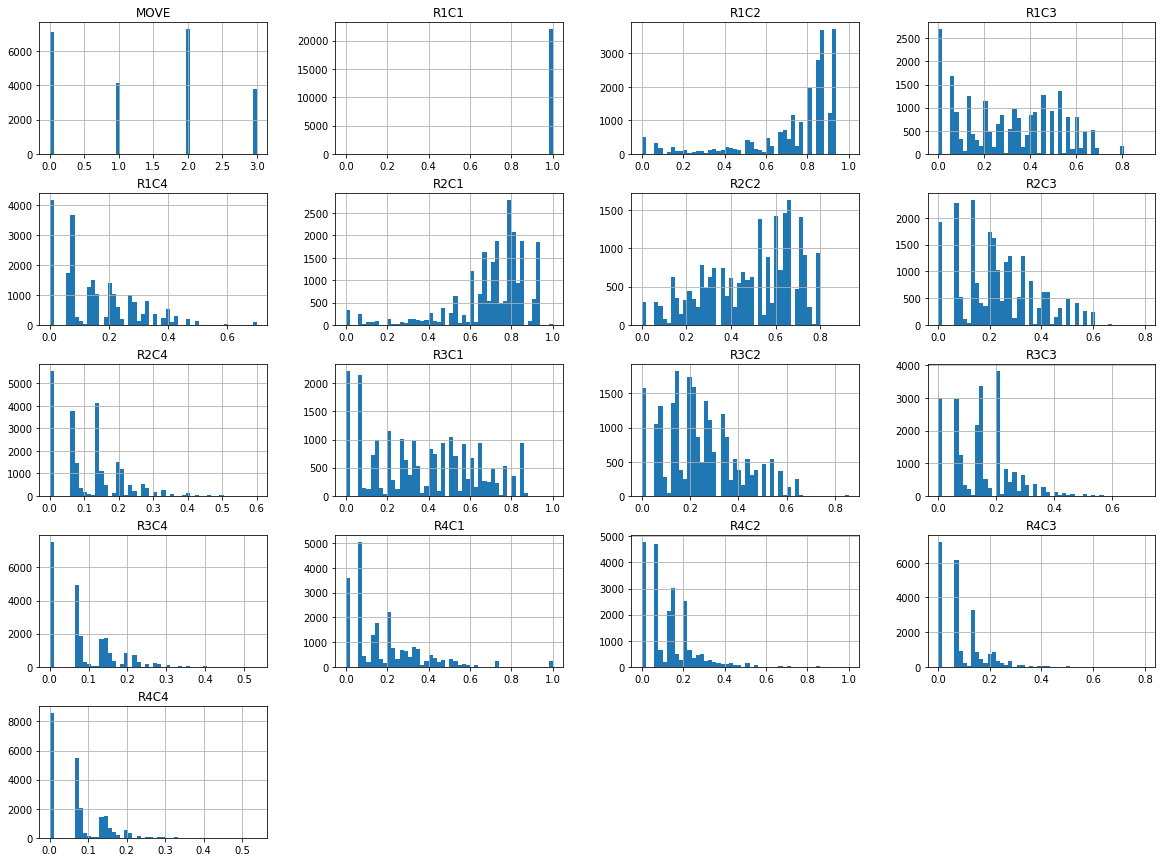

Graphs for game 2 :



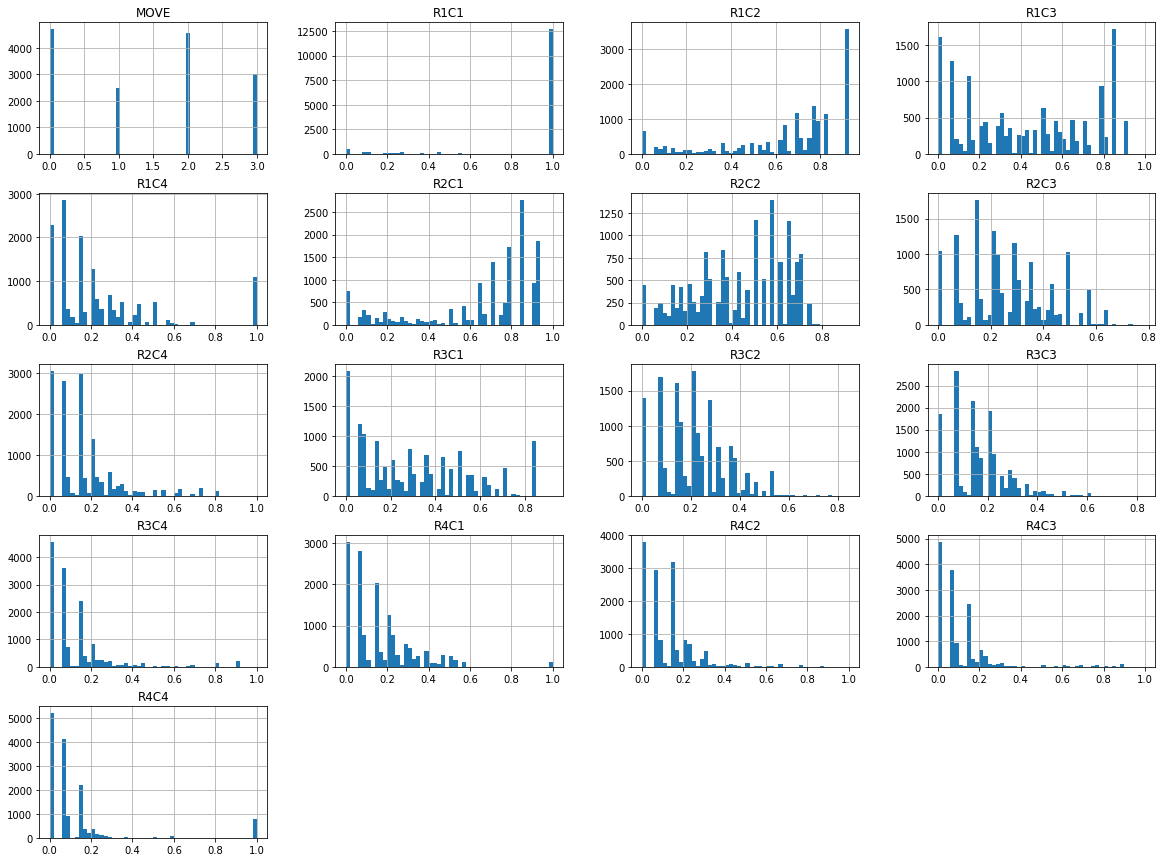

Graphs for game 3 :



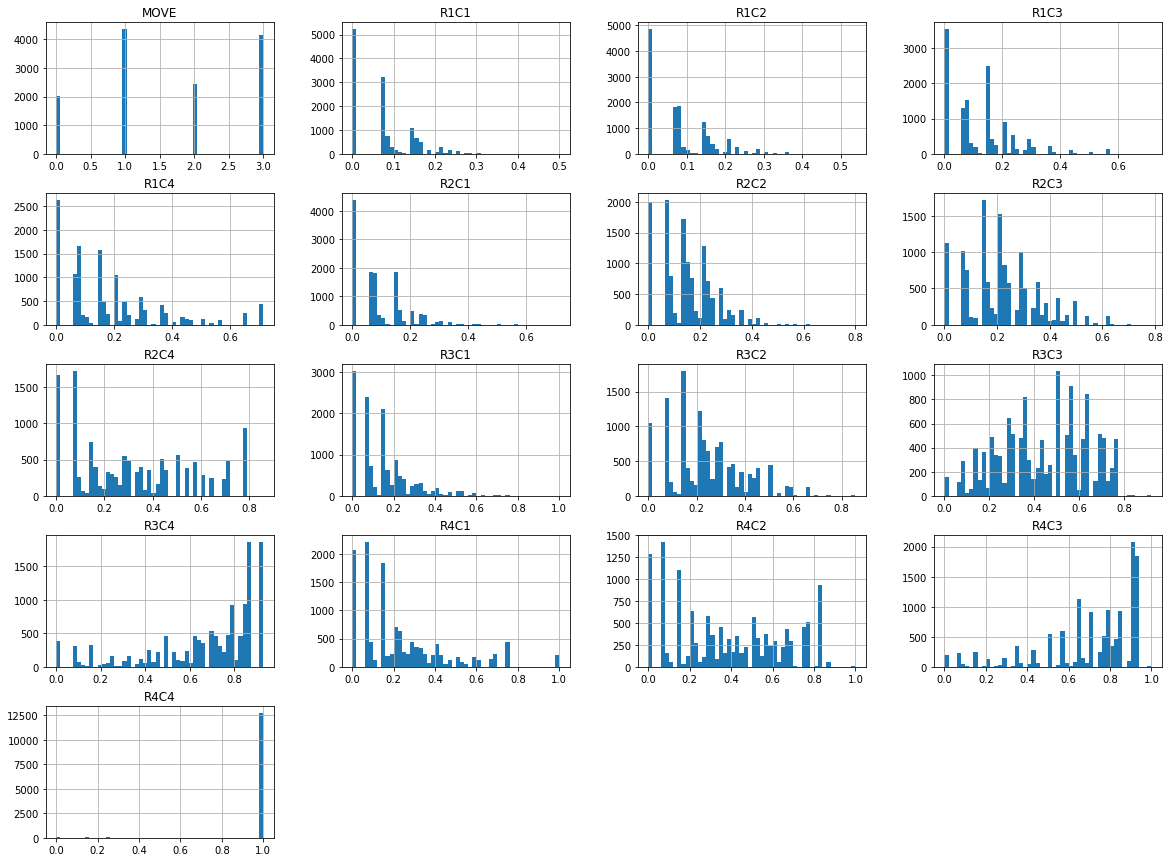

Graphs for game 4 :



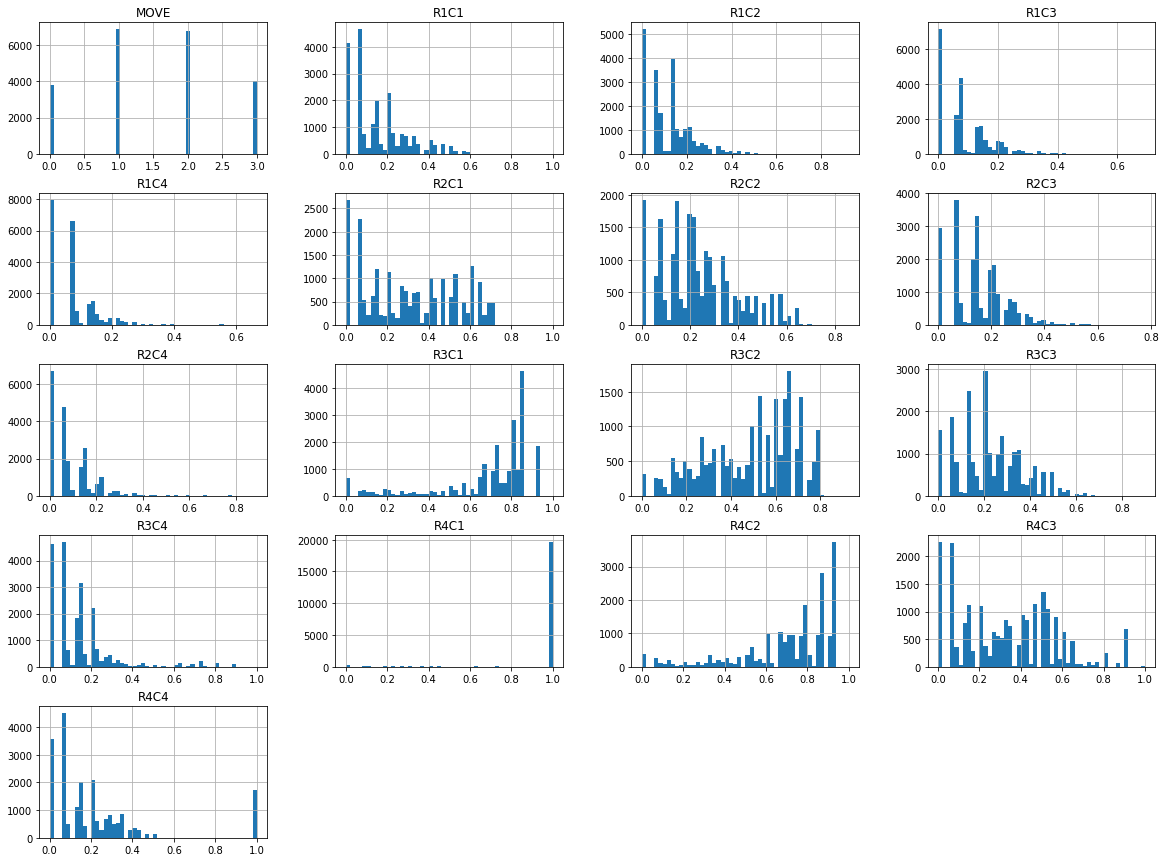

Graphs for game 5 :



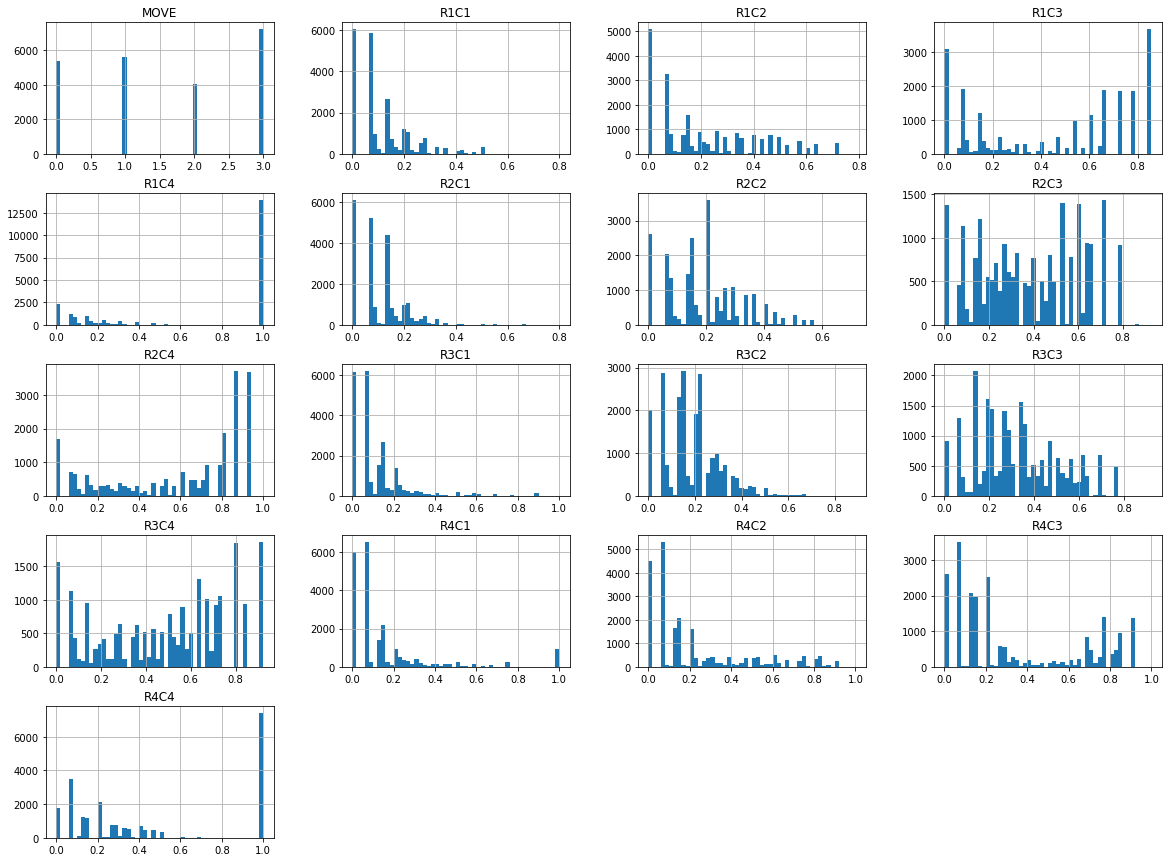

Graphs for game 6 :



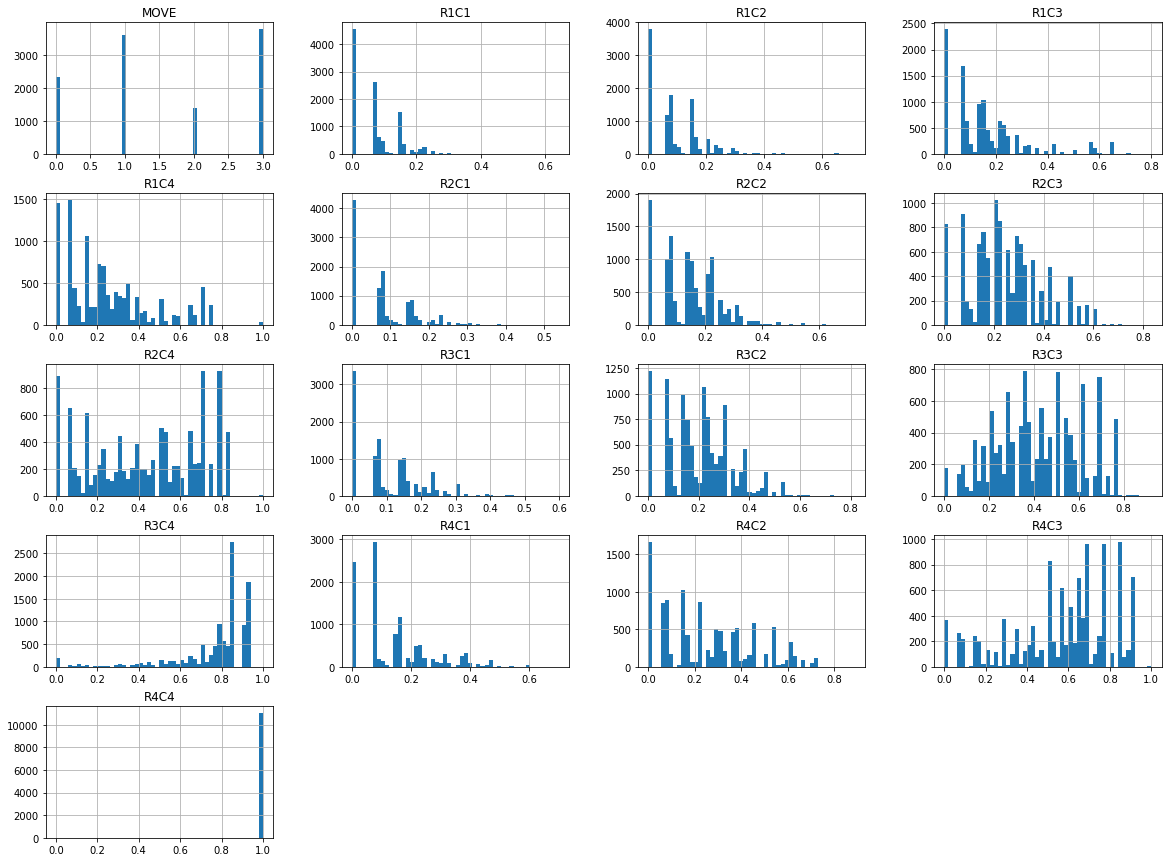

Graphs for game 7 :



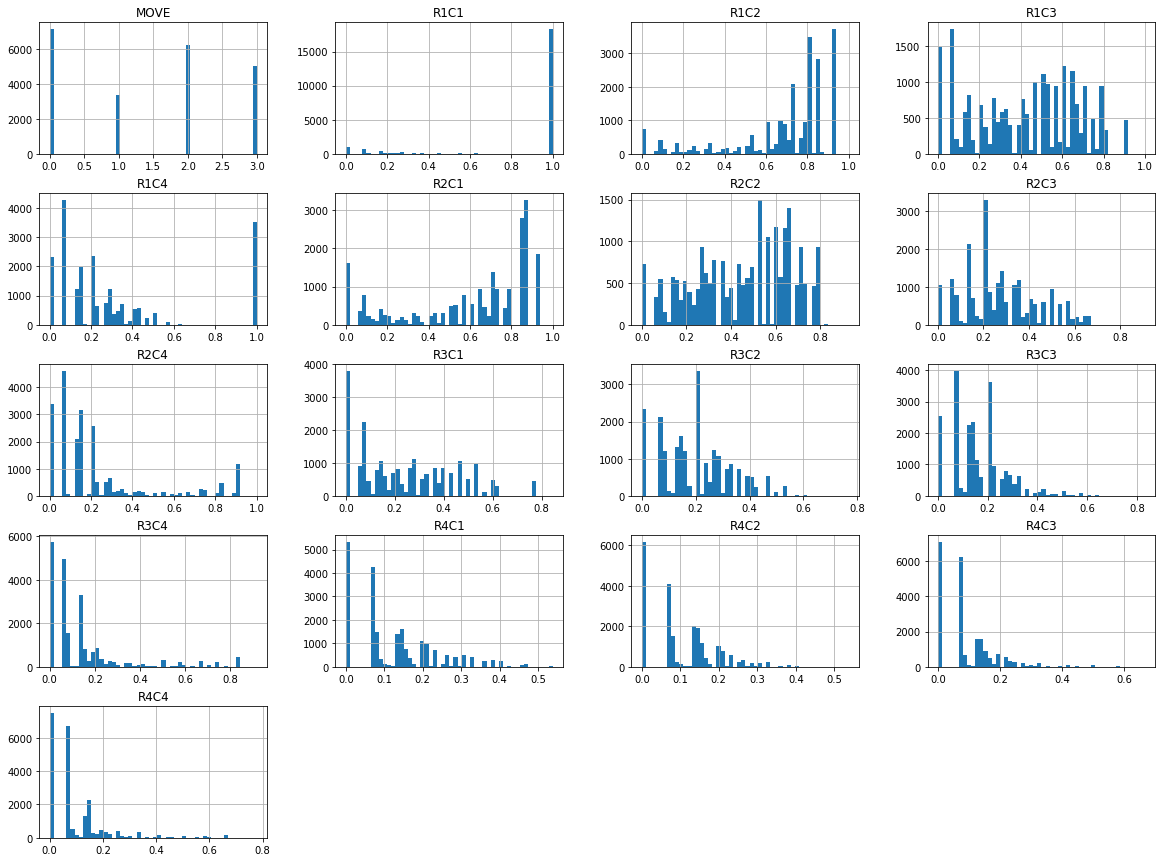

Graphs for game 8 :



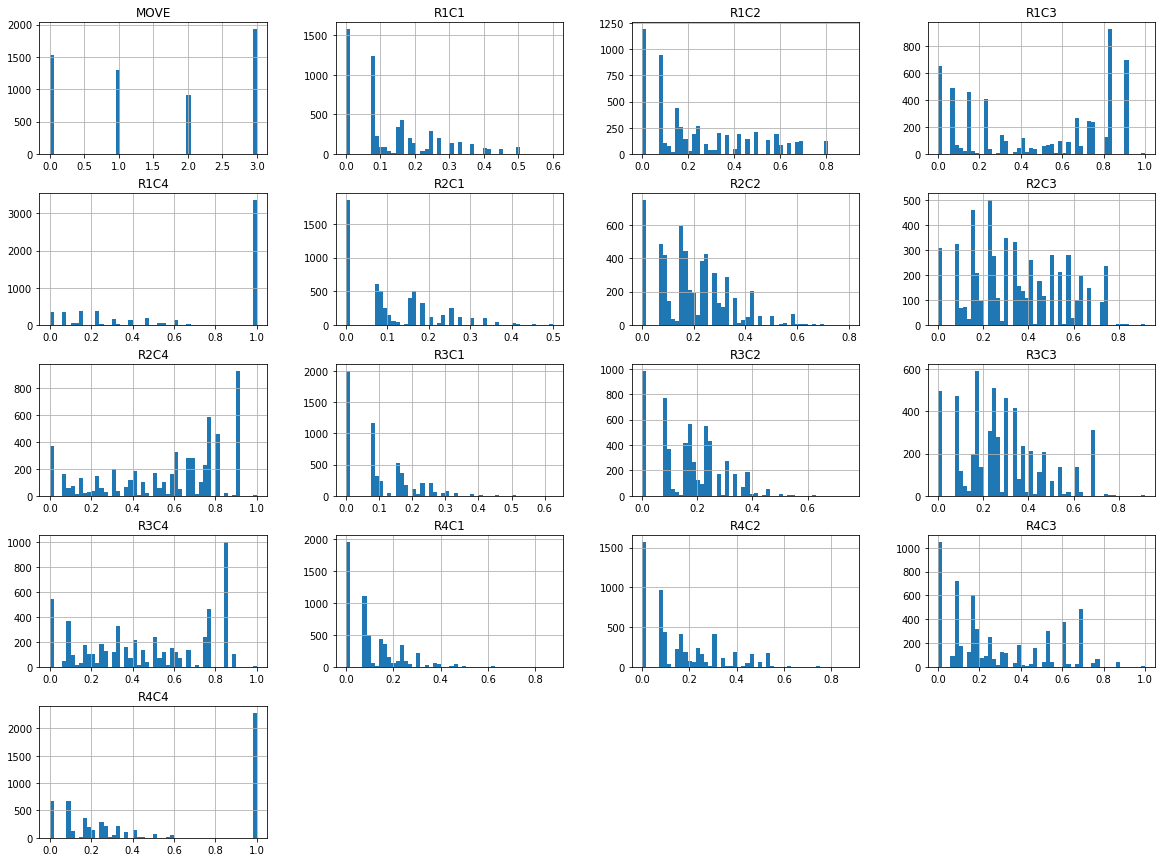

Graphs for game 9 :



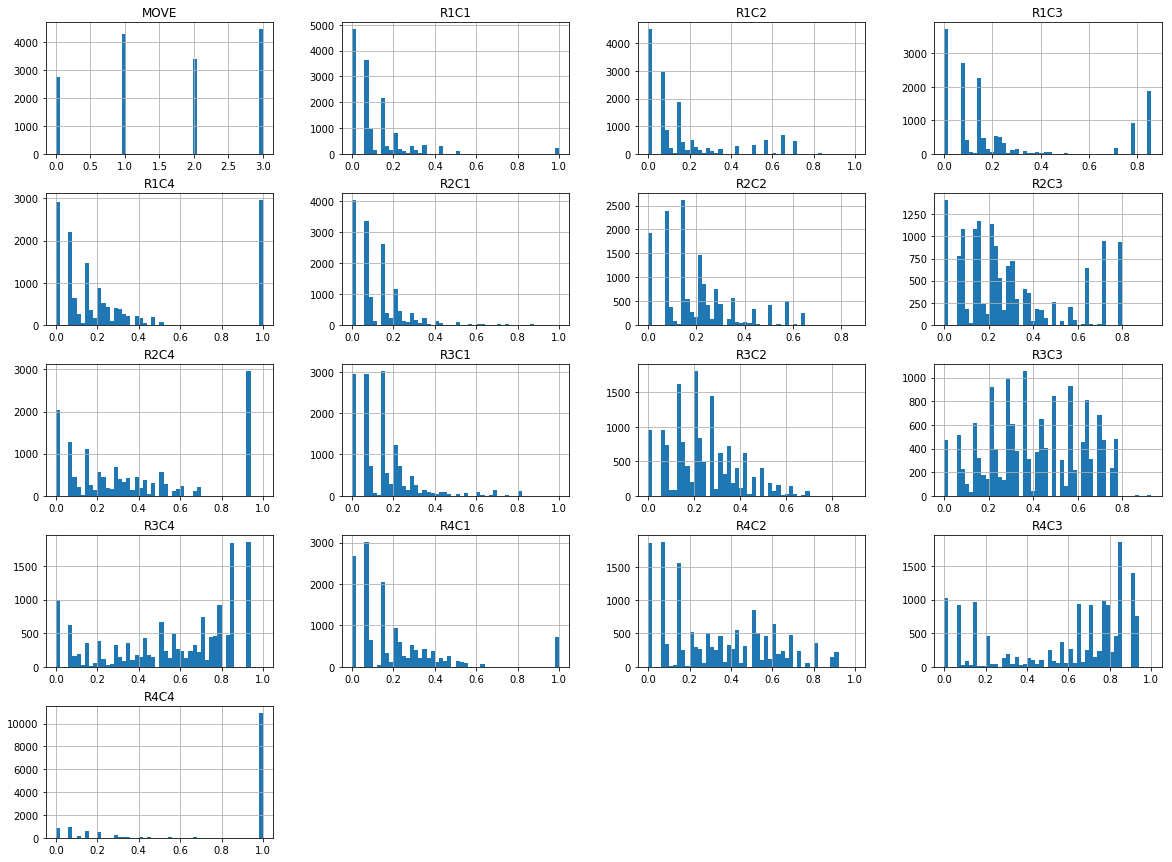

Graphs for game 10 :



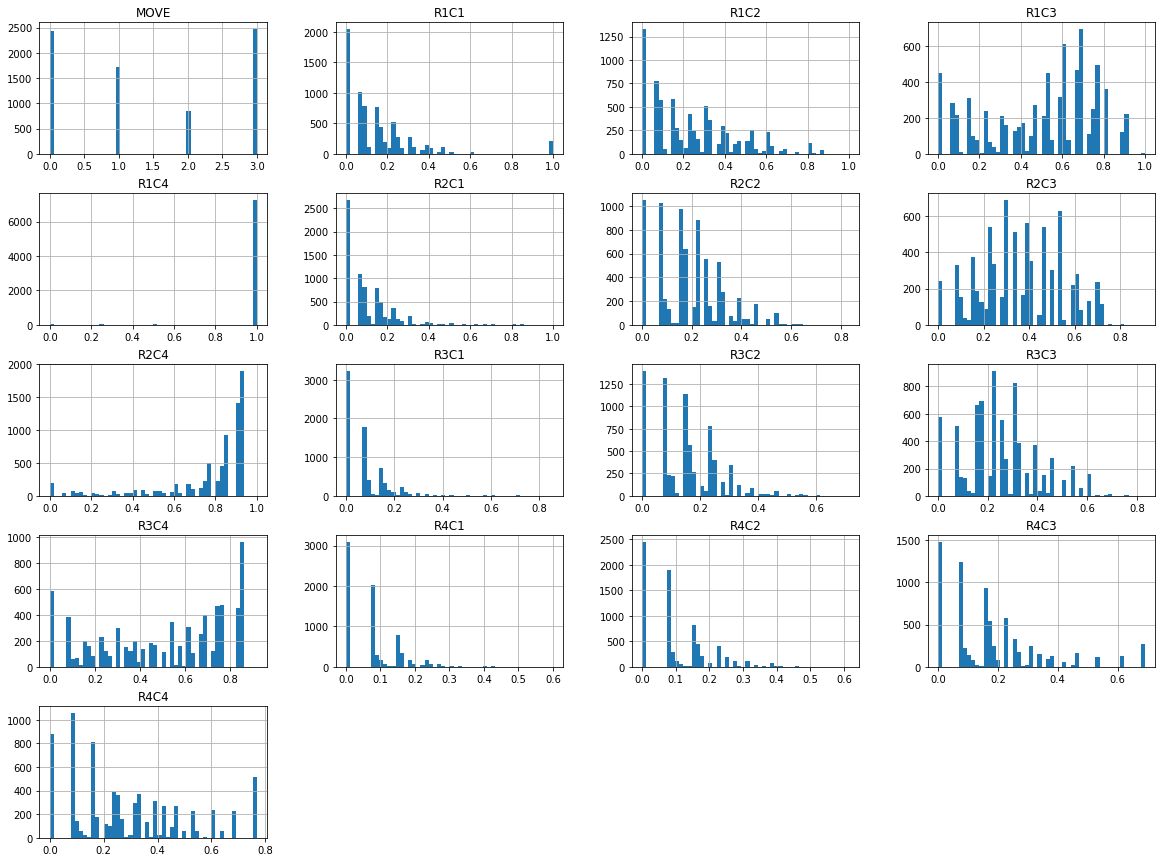

Graphs for game 11 :



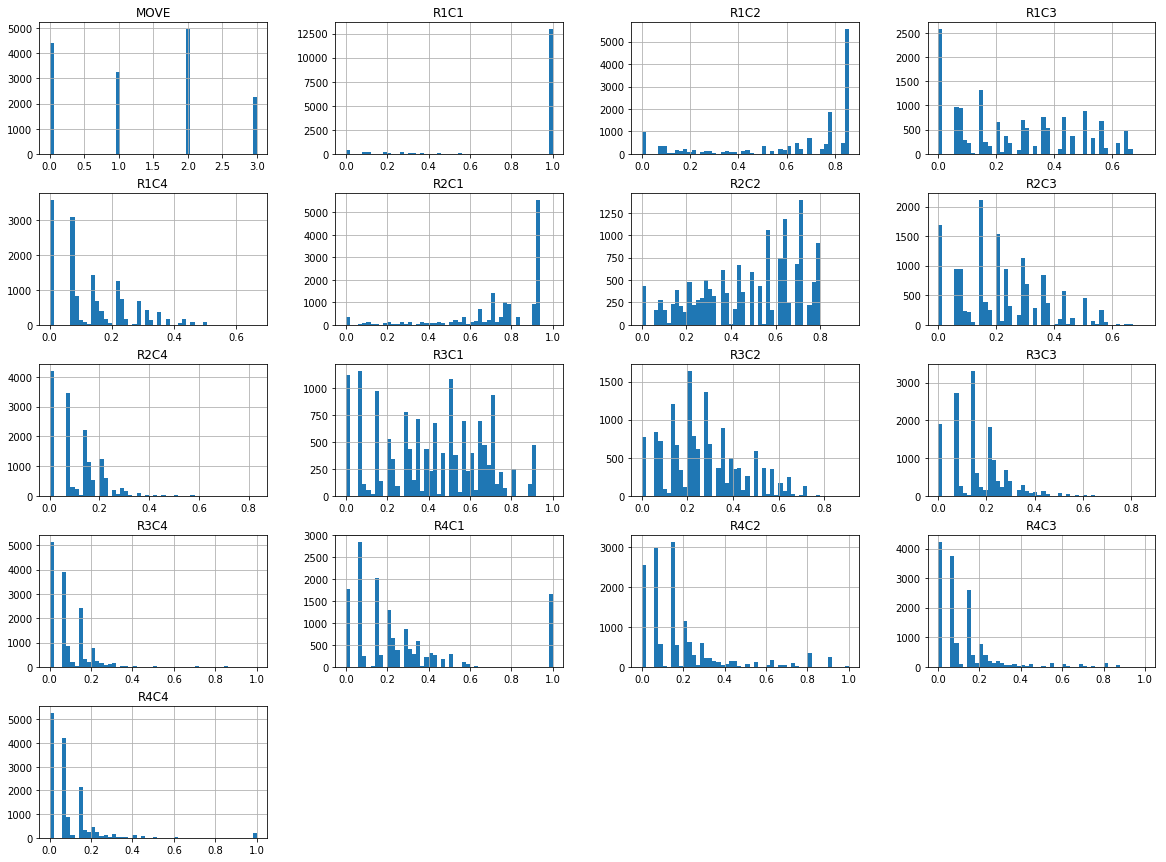

Graphs for game 12 :



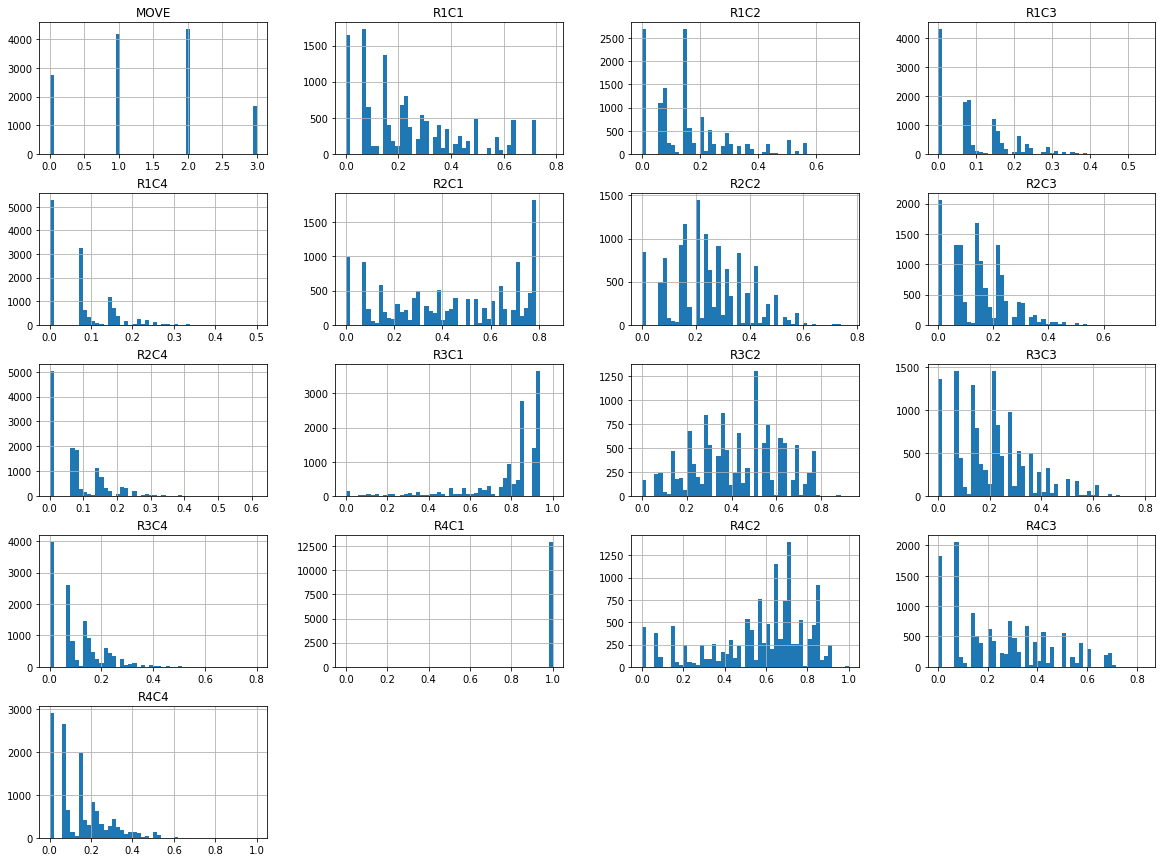

Graphs for game 13 :



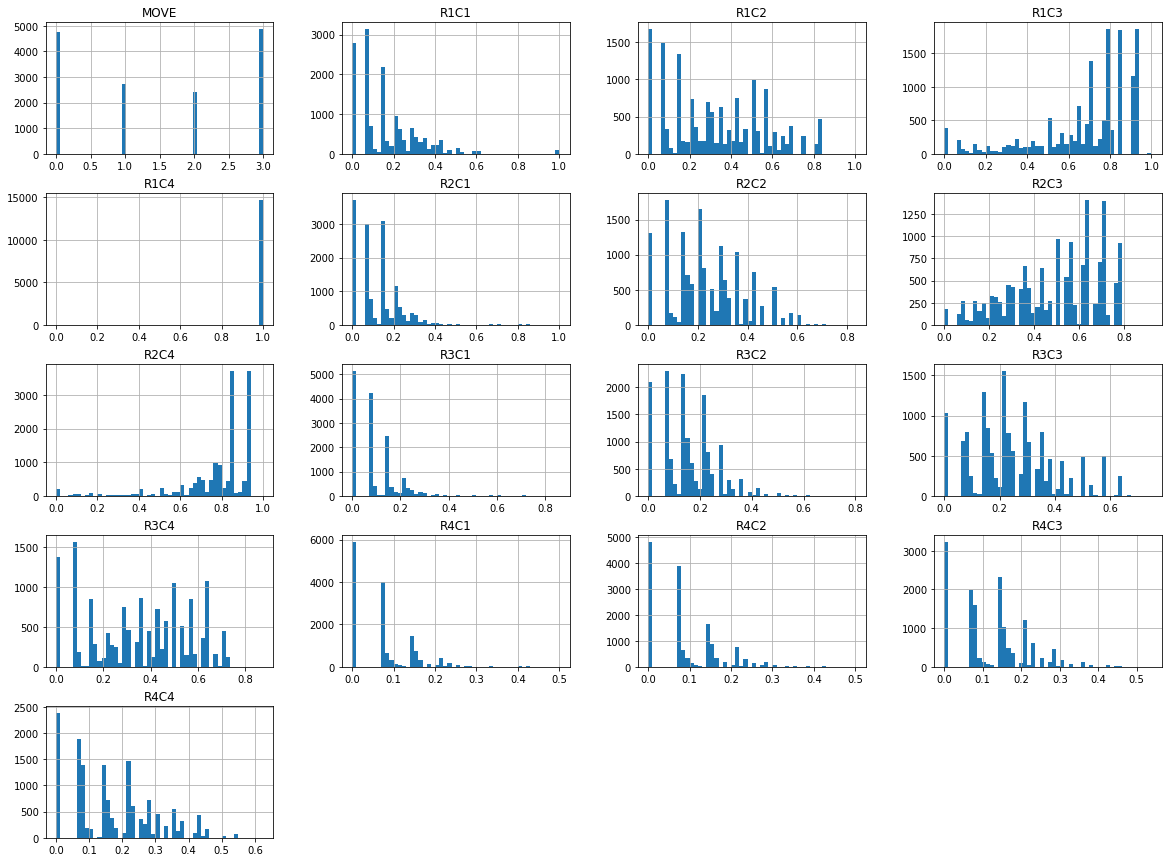

Graphs for game 14 :



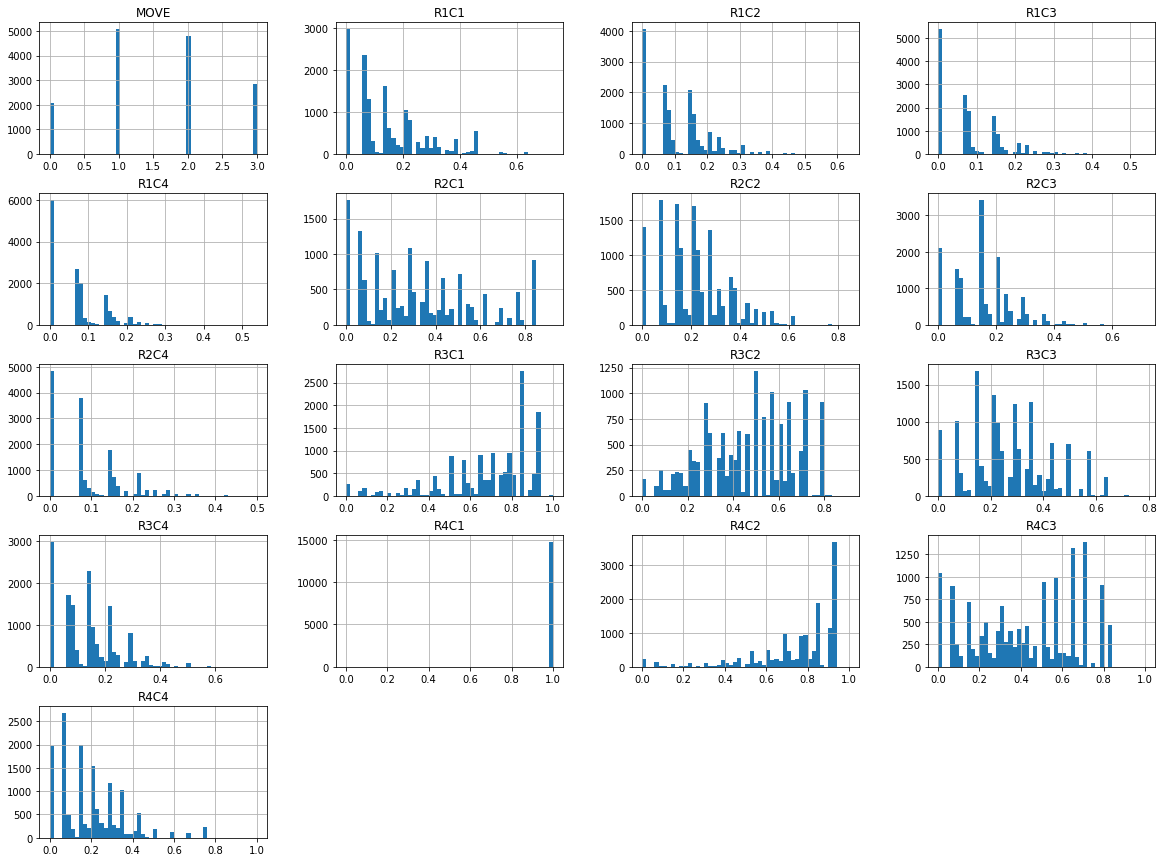

Graphs for game 15 :



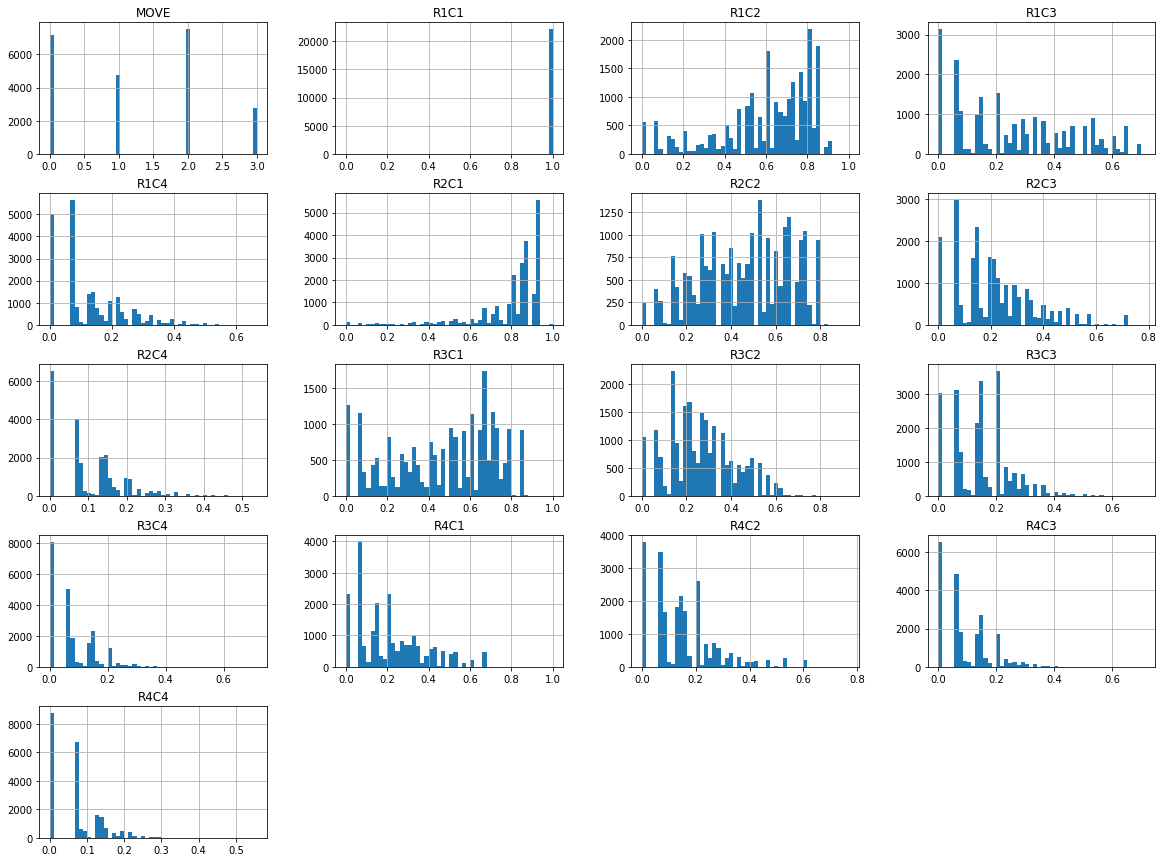

Graphs for game 16 :



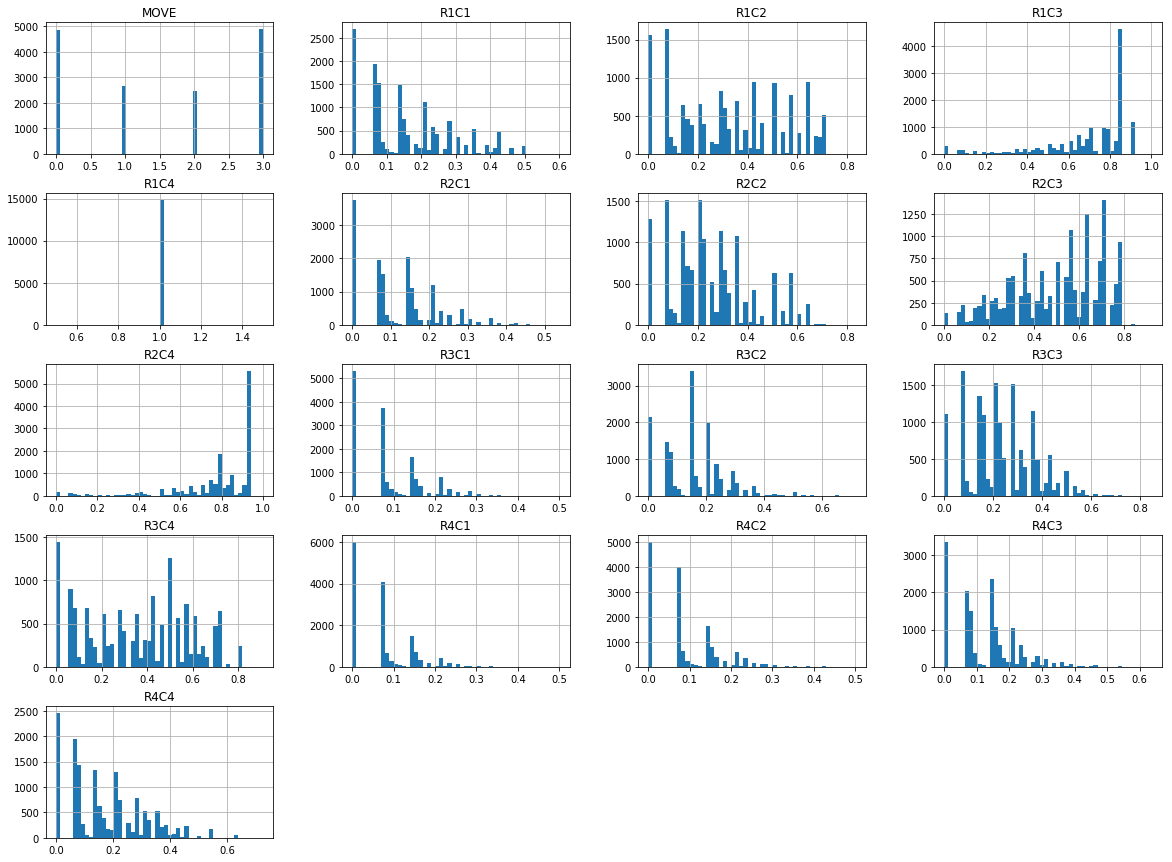

Graphs for game 17 :



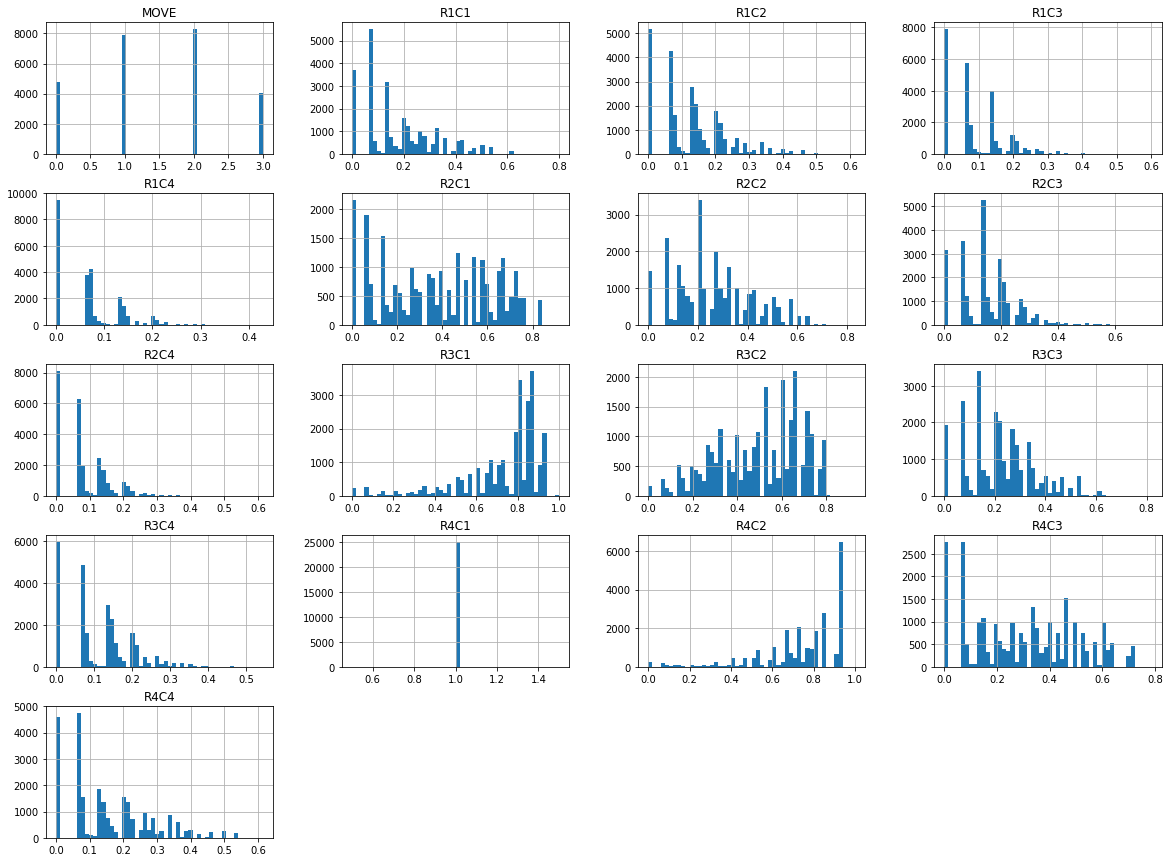

In [2]:
for n_file in range(N_FILES):
    filename = GAME_STATE_FILE_NAME + str(n_file) + GAME_STATE_FILE_EXT
    data = load_data(file=filename, direc=GAMES_DIR)
    data_col = data.columns
    data = np.float32(data.values)
    new_data = []
    for n_row in range(len(data)):
        row = data[n_row]
        if np.max(row) < MIN_CELL_VALUE_TO_QUALIFY:
            continue
            
        move = row[len(row) - 1]
        row = np.add(row, 1)
        row = np.log2(row)
        row = np.int16(row)
        row_max = np.max(row)
        row = row / row_max
        row[len(row) - 1] = np.int16(move)
        new_data.append(np.round(row, 3))
       
    data = np.array(new_data)
    processed_data = pd.DataFrame(data, columns=data_col)
    processed_data.to_csv(PROCESSED_GAMES_DIR + GAME_STATE_FILE_NAME + str(n_file) + GAME_STATE_FILE_EXT, sep=',', encoding='utf-8', index=False)
    print("Graphs for game", n_file, ":\n")
    %matplotlib inline
    processed_data.hist(bins=50, figsize=(20,15))
    plt.show()